Cluster students by skill level.

Inputs:

- gradebook data (formative assessments)
- assignment weight (100 - median grade)

Outputs:

- plot students in latent space
- kmeans clusters

In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.mixture import GaussianMixture
import string
import itertools

%matplotlib inline

,Student ID,Gender,Age,Race/Ethnicity,SPED Status,Quiz 1,Quiz 2,Quiz 3,Final Grade
0,86344,F,16,American Indian or Alaska Native,No,38.209369,32.260616,78.000829,49.490271
1,15468,F,16,Hispanic/Latino,Yes,58.908419,61.994899,95.420382,72.107900
2,83613,M,15,Asian,No,33.275808,33.603482,98.088339,54.989210
3,41012,M,16,White,No,26.939359,97.770393,51.593296,58.767683
4,48673,F,15,Native Hawaiian or Other Pacific Islander,No,46.003482,94.641732,72.754261,71.133158


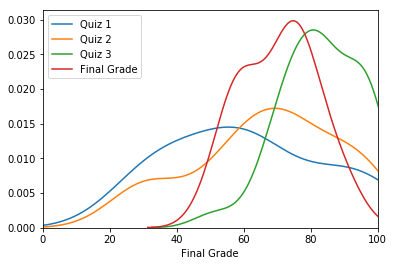

In [355]:
# 1. Simulate Data

def simulate_grades(mu, sigma, n_students):
    grades = []
    for i in range(n_students):
        g = -1
        while g<0 or g>100:
            g = np.random.normal(mu, sigma)
        grades.append(g)
    return grades


def simulate_gradebook(n_students=20):
    gb =  pd.DataFrame({'Student ID': np.random.choice(100000, n_students, replace=False),
                        'Gender': np.random.choice(['M', 'F'], n_students),
                        'Age': np.random.choice([15, 16, 16, 17], n_students),
                        'Race/Ethnicity': np.random.choice(['Hispanic/Latino', 'American Indian or Alaska Native',
                                                            'Asian', 'Black or African American',
                                                            'Native Hawaiian or Other Pacific Islander', 'White',
                                                            'Two or more races'], n_students),
                        'SPED Status': np.random.choice(['No', 'Yes'], n_students, p=[0.8, 0.2]),
                        'Quiz 1': simulate_grades(70, 30, n_students), #simulate_grades(mu, sigma, n_students)
                        'Quiz 2': simulate_grades(80, 25, n_students),
                        'Quiz 3': simulate_grades(90, 20, n_students)})
    gb['Final Grade'] = gb[['Quiz 1', 'Quiz 2', 'Quiz 3']].mean(axis='columns')
    return gb

gb = simulate_gradebook(30)
display(gb.head())

for col in ['Quiz 1', 'Quiz 2', 'Quiz 3', 'Final Grade']:
    sns.distplot(gb[col], hist=False, label=col)
plt.legend()
plt.xlim([0,100])
plt.show()

In [361]:
# 2. Cluster
n_clusters=4

# K-Means
kmeans = KMeans(n_clusters).fit(gb[['Quiz 1', 'Quiz 2', 'Quiz 3']])
gb['kmeans'] = [string.ascii_uppercase[i] for i in kmeans.labels_]

# Gaussian Mixture Model
gm = GaussianMixture(n_clusters, n_init=100).fit(gb[['Quiz 1', 'Quiz 2', 'Quiz 3']])
gb['gaussmix'] = gm.predict(gb[['Quiz 1', 'Quiz 2', 'Quiz 3']])
gb['gaussmix'] = gb['gaussmix'].map(lambda i: string.ascii_uppercase[i])

# comparison of mappings
display(gb.groupby(['kmeans', 'gaussmix']).size())

kmeans  gaussmix
A       C           8
B       A           8
        B           1
        D           1
C       B           1
        D           4
D       A           7
dtype: int64

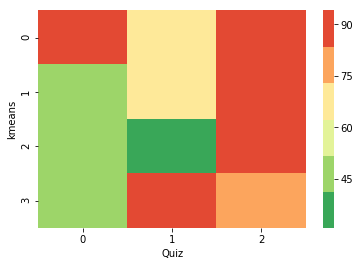

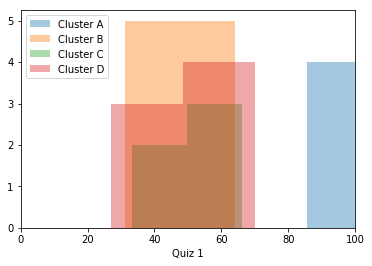

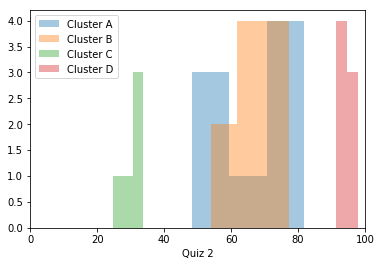

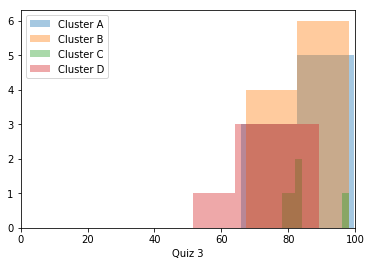

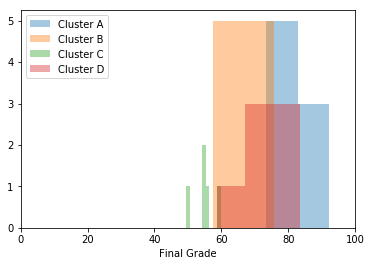

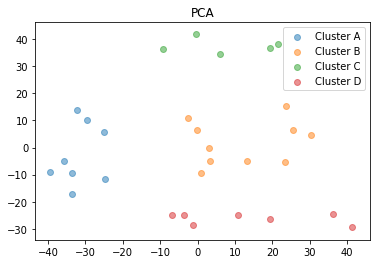

explained variance ratio: 88.8% explained [0.47677357 0.41124361]


In [363]:
# 3. Visualize Clusters

cluster_method = 'kmeans'

# K-Means
sns.heatmap(kmeans.cluster_centers_, cmap=sns.color_palette('RdYlGn_r'))
plt.xlabel('Quiz')
plt.ylabel('kmeans')
#plt.yticks(np.arange(n_clusters), string.ascii_lowercase[:n_clusters])
plt.show()


# Gaussiam Mixture Model
for col in ['Quiz 1', 'Quiz 2', 'Quiz 3', 'Final Grade']:
    for i in string.ascii_uppercase[:n_clusters]:
        sns.distplot(gb.loc[gb[cluster_method]==i, col], kde=False, label=f'Cluster {i}')
    plt.legend()
    plt.xlim([0,100])
    plt.show()
    

# PCA
X = gb[['Quiz 1', 'Quiz 2', 'Quiz 3']]
y = gb[cluster_method]
cluster_labels = gb[cluster_method].drop_duplicates().sort_values().values
target_names = cluster_labels

pca = PCA(n_components=2)
X_reduced = pca.fit(X).transform(X)

for i, target_name in zip(cluster_labels, target_names):
    plt.scatter(X_reduced[y==i, 0], X_reduced[y==i, 1], label=f'Cluster {target_name}', alpha=0.5)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')
plt.show()

# Percentage of variance explained for each components
print('explained variance ratio: {}% explained {}'
      .format(round(sum(pca.explained_variance_ratio_), 3)*100, pca.explained_variance_ratio_))

Group A: 9357, 97844, 74644, 91518, 43752, 11675, 77681, 37740
Group B: 15468, 82633, 20896, 94728, 15684, 54590, 18783, 88615, 83859, 90210
Group C: 86344, 83613, 4562, 4062, 21216
Group D: 41012, 48673, 76103, 60847, 18448, 98236, 74565


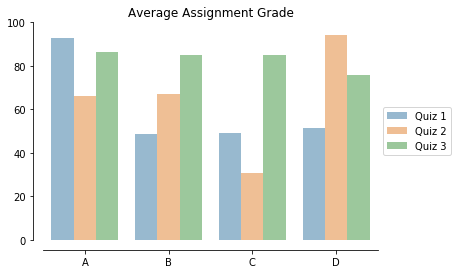

Recommendations:
Group A should focus on Quiz 2
Group B should focus on Quiz 1
Group C should focus on Quiz 2
Group D should focus on Quiz 1


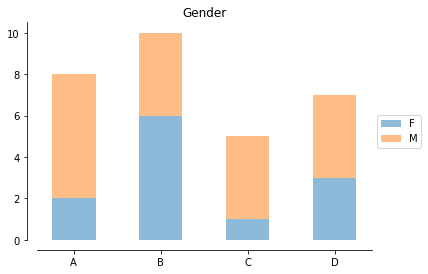

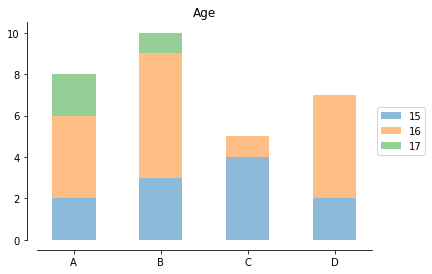

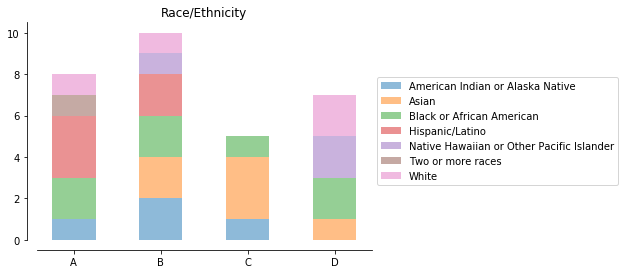

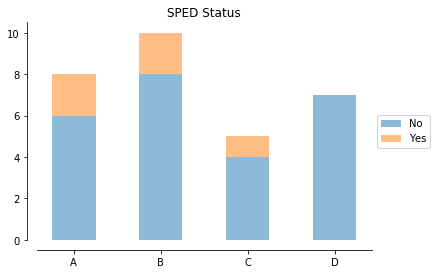

In [373]:
# 4. Describe Clusters and Offer Recommendations

# which students are in which group?
for label in string.ascii_uppercase[:n_clusters]:
    print(f"Group {label}: {', '.join(gb.loc[gb[cluster_method]==label, 'Student ID'].astype(str).values)}")

# average scores by cluster
palette = sns.color_palette()
temp = gb.groupby(cluster_method)[['Quiz 1', 'Quiz 2', 'Quiz 3']].mean()
recommendations = pd.DataFrame(temp.apply(lambda x: temp.columns[x.values.argmin()], axis='columns'))
temp = temp.stack().reset_index().rename({'level_1':'quiz', 0:'grade', cluster_method:'cluster'}, axis='columns')
b = sns.barplot('cluster', 'grade', 'quiz', data=temp, alpha=0.5, palette=palette)
sns.despine(offset=10, trim=False)
b.legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([0,100])
plt.xlabel('')
plt.ylabel('')
plt.title('Average Assignment Grade')
plt.show()

# which assignment does each group need to focus on?
print('Recommendations:')
for label in recommendations.index:
    print(f'Group {label} should focus on {recommendations.loc[label].values[0]}')

    
# similarities and differences on other characteristics (gender, age, race, SPED)
for field in ['Gender', 'Age', 'Race/Ethnicity', 'SPED Status']:
    temp = gb.groupby([cluster_method, field]).size()
    temp = temp.reindex(pd.MultiIndex.from_product(temp.index.levels),
                        fill_value=0.0)\
                .reset_index()\
                .rename({'level_0':'cluster', 'level_1':field, 0:'count'}, axis='columns')
    temp['count'] = temp['count'].astype(int)
    values = temp[field].drop_duplicates()
    palette = itertools.cycle(sns.color_palette())
    bottom = np.zeros(n_clusters)
    plots = []
    for i, value in enumerate(values):
        g = plt.bar(temp.loc[temp[field]==value, 'cluster'],
                temp.loc[temp[field]==value, 'count'],
                width=0.5, alpha=0.5, color=next(palette),
                bottom=bottom)
        plots.append(g)
        bottom = np.add(bottom, temp.loc[temp[field]==value, 'count'])
    sns.despine(offset=10, trim=False)
    plt.legend(plots, values, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(field)
    plt.show()